<a href="https://colab.research.google.com/github/Ramkanc/Hackathon2/blob/main/Ram_V2_Hackathon2_Voice_E_commerce_Ordering_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

In [ ]:
#@title Explanation Video
from IPython.display import HTML

HTML("""<video width="720" and height="400" controls>
  <source src="https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Walkthrough/Hackathon_Voice_based.mp4" type="video/mp4">
</video>
""")

# Hackathon: Voice commands based E-commerce ordering system
The goal of the hackathon is to train your model on different types of voice data (such as studio data and your own team data) and able to place order based on user preferences.

## Grading = 40 Marks

### **Objectives:**

Stage 0 - Obtain Features from Audio samples

Stage 1 (22 Marks) - Define and train a CNN model on Studio data and deploy the model in the server

Stage 2 (18 Marks) - Collect your voice samples (team data) and refine the classifier trained on Studio_data. Deploy the model in the server.

## Dataset Description

The data contains voice samples of classes - Zero, One, Two, Three, Four, Five. Each class is denoted by a numerical label from 0 to 5.

The audio files collected in a Studio dataset contain very few noise samples and all the files are in wav format.

The audio files recorded for the studio are saved with the following naming convention:

● Class Representation + user_id + sample_ID (or noise + sample_ID)

> For example: The voice sample by the user b2 recorded “Zero”, it is saved as 0_b2_35.wav. Here 35 is sample ID, 2 is the user id and ‘0’ is the label of that sample.




In [ ]:
#@title Please run the setup to download the dataset

from IPython import get_ipython
ipython = get_ipython()

notebook= "Hackathon2 - Voice E-commerce Ordering System" #name of the notebook

def setup():
    ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Hackathon_data/B17_studio_rev_data.zip")
    ipython.magic("sx unzip B17_studio_rev_data.zip ")
    print ("Setup completed successfully")

setup()

Setup completed successfully


In [ ]:
import os
import sys
import glob
import torch
import librosa
import warnings
import numpy as np
import torch.nn as nn
from time import sleep
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
warnings.filterwarnings('ignore')

## **Stage 0:** Obtain Features from Audio samples
---

### Generate features from an audio sample of '.wav' format
- Code is available to extract the features

In [ ]:
# Caution: Do not change the default parameters
def get_features(filepath, sr=8000, n_mfcc=30, n_mels=128, frames = 15):
    # The following function contains code to produce features of the audio sample.
    y, sr = librosa.load(filepath, sr=sr)
    D = np.abs(librosa.stft(y))**2
    S = librosa.feature.melspectrogram(S=D)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_S = librosa.power_to_db(S,ref=np.max)
    features = librosa.feature.mfcc(S=log_S, n_mfcc=n_mfcc)
    if features.shape[1] < frames :
        features = np.hstack((features, np.zeros((n_mfcc, frames - features.shape[1]))))
    elif features.shape[1] > frames:
        features = features[:, :frames]

    # Find 1st order delta_mfcc
    delta1_mfcc = librosa.feature.delta(features, order=1)

    # Find 2nd order delta_mfcc
    delta2_mfcc = librosa.feature.delta(features, order=2)

    # Stacking delta_mfcc features in sequence horizontally (column wise)
    features = np.hstack((delta1_mfcc.flatten(), delta2_mfcc.flatten()))

    # Increase the dimension by inserting an axis along second dimension
    features = features.flatten()[:,np.newaxis]

    # Convert the numpy.ndarray to a Tensor object
    features = Variable(torch.from_numpy(features)).float()
    return features

All the voice samples needed for training are present in the folder `"studio_data"`

In [ ]:
%ls

B17_studio_rev_data.zip  sample_data/  studio_data/


##**Stage 1**:  Define and train a CNN model on Studio data and deploy the model in the server

---


### a) Extract features of Studio data (4 Marks)

 Load 'Studio data' and extract mfcc features

 **Evaluation Criteria:**

 * Complete the code in the load_data function
 * The function should take path of the folder containing audio samples as input
 * It should return features of all the audio samples present in the specified folder into single array (list of lists or 2-d numpy array) and their respective labels should be returned too

In [ ]:
#def load_data(folder_path):
    #YOUR CODE HERE
    #return features, labels

In [ ]:
def load_data(folder_path):
    features = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            filepath = os.path.join(folder_path, filename)
            label = int(filename.split("_")[0])
            feature = get_features(filepath)
            features.append(feature)
            labels.append(label)
    return features, labels

Load data from studio_data folder for extracting all features and labels

In [ ]:
studio_recorded_features, studio_recorded_labels = load_data('/content/studio_data')


In [ ]:
#Applying normalization
#studio_recorded_features = F.normalize(torch.stack(studio_recorded_features), p=2,  dim=1)

Use train_test_split for splitting the train and test data

In [ ]:
from sklearn.model_selection import train_test_split
# YOUR CODE HERE

X_train, X_test, y_train, y_test = train_test_split(studio_recorded_features, studio_recorded_labels, test_size=0.2, random_state=42)

Load the dataset with DataLoader
- Refer to [torch.utils.data.TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset)
- Refer to [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(torch.stack(X_train), torch.tensor(y_train)) # torch.stack

In [ ]:
# YOUR CODE HERE for the DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [ ]:
# print tensor sizes of train_loader
for batch_idx, (data, target) in enumerate(train_loader):
  print("Data tensor size:", data.size())
  print("Target tensor size:", target.size())
  print(data[0].shape, "\n", max(data[0]), min(data[0]))
  break

Data tensor size: torch.Size([32, 900, 1])
Target tensor size: torch.Size([32])
torch.Size([900, 1]) 
 tensor([69.0408]) tensor([-19.6773])


### b) Define your CNN architecture (4 Marks)

[Hint](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)

In [ ]:
## Define your CNN Architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Sample Convolution Layer 1
        self.conv1 = nn.Conv1d(in_channels=900, out_channels=512, kernel_size=1)#,stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        # Sample Maxpool for the Convolutional Layer 1
        self.maxpool1 = nn.MaxPool1d(1)
        # Sample Dropout Layer
        #self.dropout = nn.Dropout(p=0.1)

        # YOUR CODE HERE for defining more number of Convolutional layers with Maxpool as required (Hint: Use at least 2 more convolutional layers for better performance)

        #Convolution Layer 2
        self.conv2 = nn.Conv1d(in_channels=512, out_channels=356, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(356)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(1)
        self.dropout = nn.Dropout(p=0.1)
        # Convolution Layer 3
        self.conv3 = nn.Conv1d(in_channels=356, out_channels=136, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(136)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool1d(1)


        # YOUR CODE HERE for defining the Fully Connected Layer and also define LogSoftmax


        # Fully Connected Layer
        self.fc1 = nn.Linear(136, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Convolution Layer 1, Maxpool and Dropout
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)
        #out = self.dropout(out)
        # YOUR CODE HERE for the Convolutional Layers and Maxpool based on the defined Convolutional layers

        #Convolution Layer 2
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = self.dropout(out)
        # Convolution Layer 3
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)

        # YOUR CODE HERE for flattening the output of the final pooling layer to a vector. Flattening is simply arranging the 3D volume of numbers into a 1D vector
        # Flatten the output of the last pooling layer
        #print("Size after conv3: ",out.shape)
        out = out.view(out.size(0), -1)
        #print("Size after flatten: ",out.shape)

        # YOUR CODE HERE for returning the output of LogSoftmax after applying Fully Connected Layer
        # Fully Connected Layer and LogSoftmax
        out = self.fc1(out)
        out = self.logsoftmax(out)

        return out

In [ ]:
# To run the training on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
model = Net()
model = model.to(device)
print(model)

#criterion = # YOUR CODE HERE : Explore and declare loss function
criterion = nn.CrossEntropyLoss()
#optimizer = # YOUR CODE HERE : Explore on the optimizer and define with the learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)
schedulaer = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=1e-6)

Net(
  (conv1): Conv1d(900, 512, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(512, 356, kernel_size=(1,), stride=(1,))
  (bn2): BatchNorm1d(356, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (conv3): Conv1d(356, 136, kernel_size=(1,), stride=(1,))
  (bn3): BatchNorm1d(136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=136, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [ ]:
from torchsummary import summary

In [ ]:
summary(model, (900, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 512, 1]         461,312
       BatchNorm1d-2               [-1, 512, 1]           1,024
              ReLU-3               [-1, 512, 1]               0
         MaxPool1d-4               [-1, 512, 1]               0
            Conv1d-5               [-1, 356, 1]         182,628
       BatchNorm1d-6               [-1, 356, 1]             712
              ReLU-7               [-1, 356, 1]               0
         MaxPool1d-8               [-1, 356, 1]               0
           Dropout-9               [-1, 356, 1]               0
           Conv1d-10               [-1, 136, 1]          48,552
      BatchNorm1d-11               [-1, 136, 1]             272
             ReLU-12               [-1, 136, 1]               0
        MaxPool1d-13               [-1, 136, 1]               0
           Linear-14                   

### c) Train and classify on the studio_data (3 Marks)

The goal here is to train the Model on voice samples collected in studio data and validate it continuously to calculate the loss and accuracy for the train dataset across each epoch.

Iterate over images in the train_loader and perform the following steps.

1. First, zero out the gradients using zero_grad()

2. Pass the data to the model. Convert the data to GPU before passing data  to the model

3. Calculate the loss using a Loss function

4. Perform Backward pass using backward() to update the weights

5. Optimize and predict by using the torch.max()

6. Calculate the accuracy of the train dataset


In [ ]:
# YOUR CODE HERE. This will take time

# Record loss and accuracy of the train dataset

In [ ]:
# First, zero out the gradients using zero_grad()
# Pass the data to the model. Convert the data to GPU before passing data to the model
# Calculate the loss using a Loss function
# Perform Backward pass using backward() to update the weights
# Optimize and predict by using the torch.max()
# Calculate the accuracy of the train dataset

num_epochs = 25

train_losses, train_accuracis = [], []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Zero out the gradients
        optimizer.zero_grad()

        # Pass the data to the model
        outputs = model(data)

        # Calculate the loss
        loss = criterion(outputs, target)

        # Perform backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Predict
        _, predicted = torch.max(outputs.data, 1)

        # Calculate accuracy
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
        train_loss += loss.item()

    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracis.append(train_accuracy)
    schedulaer.step(train_loss)
    # Print the loss and accuracy for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Learning rate {optimizer.param_groups[0]['lr']}")


Epoch [1/25], Train Loss: 1.1803, Train Accuracy: 59.57%, Learning rate 0.001
Epoch [2/25], Train Loss: 0.6728, Train Accuracy: 76.63%, Learning rate 0.001
Epoch [3/25], Train Loss: 0.5240, Train Accuracy: 81.72%, Learning rate 0.001
Epoch [4/25], Train Loss: 0.4331, Train Accuracy: 84.73%, Learning rate 0.001
Epoch [5/25], Train Loss: 0.3829, Train Accuracy: 86.27%, Learning rate 0.001
Epoch [6/25], Train Loss: 0.3253, Train Accuracy: 88.60%, Learning rate 0.001
Epoch [7/25], Train Loss: 0.2999, Train Accuracy: 89.70%, Learning rate 0.001
Epoch [8/25], Train Loss: 0.2196, Train Accuracy: 92.37%, Learning rate 0.001
Epoch [9/25], Train Loss: 0.2170, Train Accuracy: 92.15%, Learning rate 0.001
Epoch [10/25], Train Loss: 0.1908, Train Accuracy: 93.40%, Learning rate 0.001
Epoch [11/25], Train Loss: 0.1558, Train Accuracy: 94.50%, Learning rate 0.001
Epoch [12/25], Train Loss: 0.1853, Train Accuracy: 93.15%, Learning rate 0.001
Epoch [13/25], Train Loss: 0.1333, Train Accuracy: 95.70%, Le

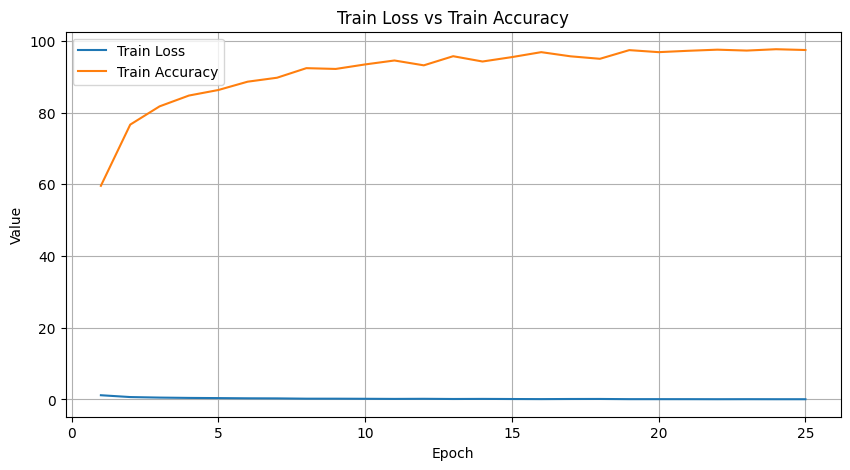

In [ ]:
# plot trainloss vs train accuracy curve

import matplotlib.pyplot as plt


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, train_accuracis, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Train Loss vs Train Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### d) Testing Evaluation for CNN model (3 Marks)

Evaluate model with the given test data

1. Transform and load the test images.

2. Pass the test data through the model (network) to get the outputs

3. Get the predictions from a maximum value using torch.max

4. Compare with the actual labels and get the count of the correct labels

5. Calculate the accuracy based on the count of correct labels

### **Expected testing accuracy is above 80%**

In [ ]:
# YOUR CODE HERE to test the model
test_data = TensorDataset(torch.stack(X_test), torch.tensor(y_test))
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
# Transform and load the test data.
# Pass the test data through the model (network) to get the outputs
# Get the predictions from a maximum value using torch.max
# Compare with the actual labels and get the count of the correct labels
# Calculate the accuracy based on the count of correct labels

model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 84.55%


### e) Save and download your model (2 Marks)

**Save your model trained on studio data**

* Save the state dictionary of the classifier (use pytorch only), It will be useful in
integrating model to the web application

 [Hint](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [ ]:
### YOUR CODE HERE for saving the CNN model
torch.save(model.state_dict(), 'studio_model.pth')

Download your trained model using the code below
* Give the path of model file to download through the browser

In [ ]:
from google.colab import files
files.download('/content/studio_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### f) Deploy and evaluate your model trained on Studio Data in the server (6 Marks).

(This can be done on the day of the Hackathon once the login username and password provided by the mentors in the lab)

Deploy your model on the server, check the hackathon document (2-Server Access and File transfer For Voice based e-commerce ordering.pdf) for details.

To order product in user interface, go through the document (3-Hackathon_II Application Interface Documentation.pdf) for details.


**Evaluation Criteria: Four consecutive utterances should be predicted correctly by the model**

- There are two stages in the e-commerce ordering application    
    - Ordering Product
    - Selecting the e-commerce platform
- If both the stages are cleared as per the evaluation criteria you will get
complete marks Otherwise, you will see a reduction in the marks

## **Stage 2:** Collect your voice samples and refine the classifier trained on studio_data and Team_data
---

### a) Collect your Team Voice Samples and extract features (6 Marks)

(This can be done on the day of the Hackathon once the login username and password is given by mentors in the lab)

* In order to collect the team data, ensure the server is active (2-Server Access and File transfer For Voice based e-commerce ordering.pdf)

* Refer document "3-Hackathon_II Application Interface Documentation.pdf" for collecting your team voice samples. These will get stored in your server

**Evaluation Criteria:**
* Load 'Team_data' and extract features
* Combine features of team data with the extracted features of studio data
* Split the combined features into train and test data
* Load the dataset with DataLoader

In [ ]:
!mkdir team_data

In [ ]:
# Replace <YOUR_GROUP_ID> with your Username given in the lab
!wget -r -A .wav https://aiml-sandbox1.talentsprint.com/audio_recorder/<YOUR_GROUP_ID>/team_data/ -nH --cut-dirs=100  -P ./team_data

/bin/bash: line 1: YOUR_GROUP_ID: No such file or directory


In [ ]:
# YOUR CODE HERE to Load data from teamdata folder for extracting all features and labels

In [ ]:
# Combine the features of all voice samples (studio_data and teamdata)
# YOUR CODE HERE

In [ ]:
# YOUR CODE HERE to split the combined features into train and test data (Hint: Use train_test_split)

In [ ]:
# YOUR CODE HERE to load the dataset with DataLoader

### b) Classify and download the model (6 Marks)

The goal here is to train and test your model on all voice samples collected in studio and team data

**Evaluation Criteria:**
* Refine your classifier (if needed)
* Train your model on the extracted train data
* Test your model on the extracted test data
* Save and download the trained model

### **Expected testing accuracy is above 80%**

In [ ]:
# YOUR CODE HERE for refining your classifier (if needed)

In [ ]:
# YOUR CODE HERE to train your model

# Record loss and accuracy of the train dataset

In [ ]:
# YOUR CODE HERE to test your model

**Save your trained model**

* Save the state dictionary of the classifier (use pytorch only), It will be useful in
integrating model to the web application

 [Hint](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [ ]:
### YOUR CODE HERE for saving the CNN model
torch.save(model.state_dict(), 'my_model.pth')

Download your trained model using the code below
* Give the path of model file to download through the browser

In [ ]:
from google.colab import files
files.download('/content/my_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### c) Deploy and evaluate your model trained on Studio Data + Team Data in the server (6 Marks).

(This can be done on the day of the Hackathon once the login username and password provided by the mentors in the lab)

Deploy your model on the server, check the hackathon document (2-Server Access and File transfer For Voice based e-commerce ordering.pdf) for details.

To order product in user interface, go through the document (3-Hackathon_II Application Interface Documentation.pdf) for details.


**Evaluation Criteria: Four consecutive utterances should be predicted correctly by the model**

- There are two stages in the e-commerce ordering application    
    - Ordering Product
    - Selecting the e-commerce platform
- If both the stages are cleared as per the evaluation criteria you will get
complete marks Otherwise, you will see a reduction in the marks